<div align="center"> 
    <hr>
  <font size="6"><b>Dev | Clean-Clean Entity Resolution Notebook</b> </font>
   <hr>
</div>

In [1]:
!python --version

Python 3.10.9


In [2]:
import os
import sys
import pandas as pd
import networkx
from networkx import draw, Graph
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from pyjedai.utils import (
    text_cleaning_method,
    print_clusters,
    print_blocks,
    print_candidate_pairs
)
from pyjedai.evaluation import Evaluation, write
from pyjedai.datamodel import Data
d1 = pd.read_csv("./data/ccer/D2/abt.csv", sep='|', engine='python', na_filter=False).astype(str)
d2 = pd.read_csv("./data/ccer/D2/buy.csv", sep='|', engine='python', na_filter=False).astype(str)
gt = pd.read_csv("./data/ccer/D2/gt.csv", sep='|', engine='python')

data = Data(
    dataset_1=d1,
    attributes_1=['id','name','description'],
    id_column_name_1='id',
    dataset_2=d2,
    attributes_2=['id','name','description'],
    id_column_name_2='id',
    ground_truth=gt,
)

# Block Building

In [3]:
from pyjedai.block_building import (
    StandardBlocking,
    QGramsBlocking,
    ExtendedQGramsBlocking,
    SuffixArraysBlocking,
    ExtendedSuffixArraysBlocking,
)

In [4]:
qgb = QGramsBlocking(qgrams=6)
blocks = qgb.build_blocks(data, attributes_1=['name'], attributes_2=['name'])

Q-Grams Blocking:   0%|          | 0/2152 [00:00<?, ?it/s]

In [5]:
qgb.evaluate(blocks, with_classification_report=True)

***************************************************************************************************************************
                                         Μethod:  Q-Grams Blocking
***************************************************************************************************************************
Method name: Q-Grams Blocking
Parameters: 
	Q-Gramms: 6
Runtime: 0.0781 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      0.32% 
	Recall:        99.91%
	F1-score:       0.63%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Classification report:
	True positives: 1075
	False positives: 337743
	True negatives: 820032
	False negatives: 1
	Total comparisons: 338818
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


{'Precision %': 0.3172794833804579,
 'Recall %': 99.90706319702602,
 'F1 %': 0.6325501479873138,
 'True Positives': 1075,
 'False Positives': 337743,
 'True Negatives': 820032,
 'False Negatives': 1}

# Block Cleaning

In [6]:
from pyjedai.block_cleaning import BlockFiltering

In [7]:
bf = BlockFiltering(ratio=0.8)
filtered_blocks = bf.process(blocks, data, tqdm_disable=False)

Block Filtering:   0%|          | 0/3 [00:00<?, ?it/s]

# Comparison Cleaning


In [8]:
from pyjedai.block_cleaning import BlockPurging

In [9]:
cbbp = BlockPurging()
cleaned_blocks = cbbp.process(filtered_blocks, data, tqdm_disable=False)

Block Purging:   0%|          | 0/4984 [00:00<?, ?it/s]

In [10]:
cbbp.evaluate(cleaned_blocks, with_classification_report=True)

***************************************************************************************************************************
                                         Μethod:  Block Purging
***************************************************************************************************************************
Method name: Block Purging
Parameters: 
	Smoothing factor: 1.025
	Max Comparisons per Block: 3944.0
Runtime: 0.0274 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      0.82% 
	Recall:        98.98%
	F1-score:       1.62%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Classification report:
	True positives: 1065
	False positives: 129182
	True negatives: 1028583
	False negatives: 11
	Total comparisons: 130247
──────────────────────────────────────────────────────────────────────────────────────────

{'Precision %': 0.8176771825838598,
 'Recall %': 98.97769516728626,
 'F1 %': 1.6219550269183616,
 'True Positives': 1065,
 'False Positives': 129182,
 'True Negatives': 1028583,
 'False Negatives': 11}

# Progressive Entity Matching

Applies Entity Matching to a subset of candidate pairs based on prioritization scheme.

In [89]:
from pyjedai.prioritization import (
    GlobalTopPM,
    LocalTopPM,
    EmbeddingsNNBPM,
    GlobalPSNM,
    LocalPSNM,
    RandomPM,
    PESM
)

In [90]:
%%time
LTPM = LocalTopPM(
    budget = 10000,
    w_scheme = 'X2',
    metric='dice',
    similarity_threshold=0.1,
    attributes = ['description', 'name']
)

ltpm_pairs_graph = LTPM.predict(cleaned_blocks, data, tqdm_disable=True)

CPU times: user 2.85 s, sys: 12.3 ms, total: 2.86 s
Wall time: 2.86 s


In [91]:
%%time
GTPM = GlobalTopPM(
    budget = 10000,
    w_scheme = 'X2',
    metric='dice',
    similarity_threshold=0.1,
    attributes = ['description', 'name']
)

gtpm_pairs_graph = GTPM.predict(cleaned_blocks, data, tqdm_disable=True)

CPU times: user 1.43 s, sys: 112 µs, total: 1.43 s
Wall time: 1.42 s


In [92]:
%%time
GPSNM = GlobalPSNM(
    budget = 10000,
    pwScheme = 'ID',
    metric='dice',
    similarity_threshold=0.1,
    attributes = ['description', 'name']
)

gpsnm_pairs_graph = GPSNM.predict(cleaned_blocks, data, tqdm_disable=True)

CPU times: user 410 ms, sys: 0 ns, total: 410 ms
Wall time: 411 ms


In [93]:
%%time
LPSNM = LocalPSNM(
    budget = 10000,
    pwScheme = 'ID',
    metric='dice',
    similarity_threshold=0.1,
    attributes = ['description', 'name']
)

lpsnm_pairs_graph = LPSNM.predict(cleaned_blocks, data, tqdm_disable=True)

CPU times: user 77.7 ms, sys: 0 ns, total: 77.7 ms
Wall time: 77 ms


In [94]:
%%time
ENNBPM = EmbeddingsNNBPM(
    budget = 10000,
    vectorizer = 'roberta',
    similarity_search = 'faiss',
    emission= 'avg',
    metric = 'dice',
    tokenizer = 'white_space_tokenizer',
    similarity_threshold = 0.1
)
ennbpm_pairs_graph = ENNBPM.predict(candidate_pairs_blocks, data, wep, tqdm_disable=True)

NameError: name 'candidate_pairs_blocks' is not defined

In [95]:
%%time
rpm = RandomPM(
    budget = 10000,
    metric='dice',
    similarity_threshold=0.1,
    attributes = ['description', 'name']
)

rpm_pairs_graph = rpm.predict(cleaned_blocks, data, tqdm_disable=True)

CPU times: user 45.8 ms, sys: 24 µs, total: 45.9 ms
Wall time: 45.1 ms


In [96]:
%%time
pesm = PESM(
    budget = 10000,
    w_scheme = 'X2',
    metric='dice',
    similarity_threshold=0.1,
    attributes = ['description', 'name']
)

pesm_pairs_graph = pesm.predict(cleaned_blocks, data, tqdm_disable=True)

CPU times: user 6.72 s, sys: 15.8 ms, total: 6.73 s
Wall time: 6.77 s


In [69]:
def reverse(id1, id2):
    if(id1 > id2):
        return (id2, id1)
    else:
        return (id1, id2)

def get_duplicates(tuple_list):
    count = 0
    seen_pairs = set()
    duplicates = []
    
    for item in tuple_list:
        weight, id1, id2 = item
        pair = reverse(id1, id2)
        
        if pair in seen_pairs:
            dupl.append(pair)
        else:
            seen_pairs.add(pair)
    
    return duplicates

In [104]:
# some progressive methods don't allow for comparison storage within graph
# it changes the order of the emitted pairs
methods_prediction_data = []

# ltpm_pairs_graph.edges = sorted(ltpm_pairs_graph.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)
# gtpm_pairs_graph.edges = sorted(gtpm_pairs_graph.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)

# ltpm_pairs_graph.edges = [edge[:2] for edge in ltpm_pairs_graph.edges]
# gtpm_pairs_graph.edges = [edge[:2] for edge in gtpm_pairs_graph.edges]


# ltpm_pairs_graph
# gtpm_pairs_graph
# rpm_pairs_graph
# gpsnm_pairs_graph
# lpsnm_pairs_graph
# pesm_pairs_graph

methods_prediction_data.append(("Random", [edge for edge in rpm_pairs_graph.edges]))
methods_prediction_data.append(("Local Top", [edge[:2] for edge in ltpm_pairs_graph.edges]))
methods_prediction_data.append(("Global Top", [edge[:2] for edge in gtpm_pairs_graph.edges]))
methods_prediction_data.append(("GSN", gpsnm_pairs_graph))
methods_prediction_data.append(("LSN", lpsnm_pairs_graph))
methods_prediction_data.append(("ES", pesm_pairs_graph))


# methods_prediction_data.append(("Random", list([edge[:2] for edge in rpm_pairs_graph.edges])))
# methods_prediction_data.append(("Entity Esch", list(edge[1:] for edge in pesm_pairs_graph)))
# methods_prediction_data.append(("Global Sorted Neighborhood", gpsnm_pairs_graph))
# methods_prediction_data.append(("Local Sorted Neighborhood", lpsnm_pairs_graph))
# methods_prediction_data.append(("Embedding BNN", list(ennbpm_pairs_graph)))

0.12825278810408922
10000
0.9656133828996283
12874
0.9330855018587361
10000
0.8345724907063197
10000
0.8866171003717472
10000
1.3141263940520447
10000


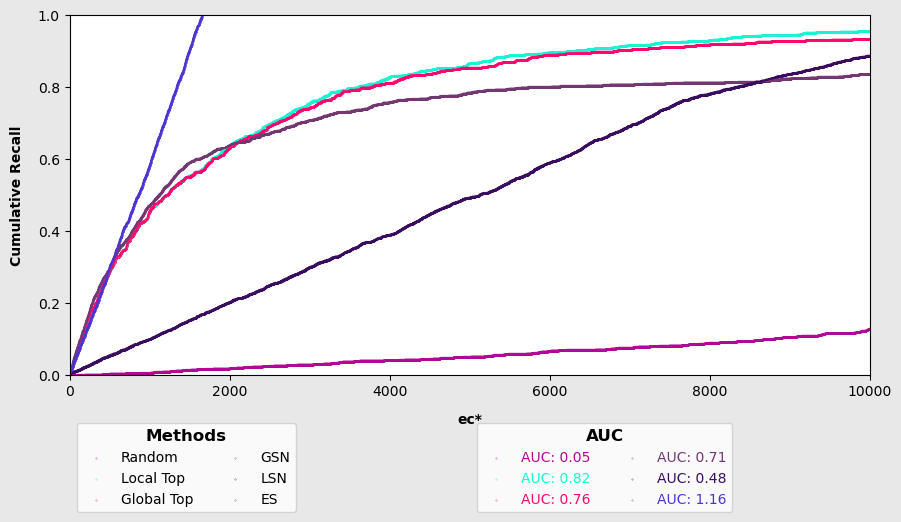

CPU times: user 439 ms, sys: 32 µs, total: 439 ms
Wall time: 439 ms


In [105]:
%%time
GPSNM.evaluate_auc_roc(methods_prediction_data = methods_prediction_data, proportional = False)

# Entity Clustering

It takes as input the similarity graph produced by Entity Matching and partitions it into a set of equivalence clusters, with every cluster corresponding to a distinct real-world object.

In [ ]:
from pyjedai.clustering import ConnectedComponentsClustering, UniqueMappingClustering

In [ ]:
ccc = ConnectedComponentsClustering()
clusters = ccc.process(pairs_graph, data)

In [ ]:
ccc.evaluate(clusters, with_classification_report=True)

In [ ]:
from pyjedai.clustering import ConnectedComponentsClustering, UniqueMappingClustering
umc = UniqueMappingClustering()
clusters = umc.process(pairs_graph, data)

In [ ]:
umc.evaluate(clusters, with_classification_report=True)